# Product Matching

This notebook is presented in the Product Matching webinar, one of many interesting webinars given by Turi. Check out upcoming webinars [here](https://turi.com/events/). <br>
We will use GraphLab Create to perform product matching between textual descriptions of products from different sources, a task also known as Record Linkage. The data is available [here](http://dbs.uni-leipzig.de/en/research/projects/object_matching/fever/benchmark_datasets_for_entity_resolution).

The notebook is orginaized into the following sections:
- <a href="#load">Loading and cleaning the data</a>
- <a href="#eval">Evaluation functions</a>
- <a href="#model">Record Linker model</a>
- <a href="#feature">Feature Engineering</a>
- <a href="#k">Exploring parameters</a>

## <a id="load"></a> Loading and cleaning the data

In [1]:
import graphlab as gl
import re
import matplotlib.pyplot as plt

gl.canvas.set_target('ipynb')
%matplotlib inline

This commercial license of GraphLab Create is assigned to engr@turi.com.


2016-05-19 11:07:15,655 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1463645233.log


In [2]:
amazon = gl.SFrame.read_csv('Amazon.csv', verbose=False)
google = gl.SFrame.read_csv('GoogleProducts.csv', verbose=False)
truth = gl.SFrame.read_csv('Amzon_GoogleProducts_perfectMapping.csv', verbose=False)

In [3]:
print 'Amazon length: ', amazon.num_rows()

amazon.head(2)

Amazon length:  1363


id,title,description,manufacturer,price
b000jz4hqo,clickart 950 000 -premier image pack (dvd- ...,,broderbund,0.0
b0006zf55o,ca international -arcserve lap/desktop oem ...,oem arcserve backup v11.1win 30u for laptops and ...,computer associates,0.0


In [4]:
print 'Google length: ', google.num_rows()

google.head(2)

Google length:  3226


id,name,description,manufacturer,price
http://www.google.com/base/feeds/snippets/1112 ...,learning quickbooks 2007,learning quickbooks 2007,intuit,38.99
http://www.google.com/base/feeds/snippets/1153 ...,superstart! fun withreading & writing! ...,fun with reading &writing! is designed to ...,,8.49


In [5]:
print 'Truth length: ', truth.num_rows()

truth.head(2)

Truth length:  1300


idAmazon,idGoogleBase
b000jz4hqo,http://www.google.com/base/feeds/snippets/1844 ...
b00004tkvy,http://www.google.com/base/feeds/snippets/1844 ...


In [6]:
def transform(truth, amazon, google):
    '''Transform the data into a more manageable format'''
    
    # For the sake of this webinar we will look only at the names of the products
    amazon = amazon[['id', 'title']]
    google = google[['id', 'name']]
    
    # Add a unique numeric label
    amazon = amazon.add_row_number(column_name='label')
    google = google.add_row_number(column_name='label')
    
    # Change labels in truth based on the new numerical labels
    truth = truth.join(amazon, on={'idAmazon' : 'id'})
    truth = truth.join(google, on={'idGoogleBase' : 'id'})
    
    # Rename some columns
    amazon = amazon.rename({'title' : 'name'})
    truth = truth.rename({
        'label' : 'amazon label',
        'title' : 'amazon name',
        'label.1' : 'google label',
        'name' : 'google name'
    })
    
    # Remove some others
    truth.remove_columns(['idGoogleBase', 'idAmazon'])
    amazon = amazon.remove_column('id')
    google = google.remove_column('id')
    
    return truth, amazon, google

truth, amazon, google = transform(truth, amazon, google)

In [7]:
amazon.head(3)

label,name
0,clickart 950 000 -premier image pack (dvd- ...
1,ca international -arcserve lap/desktop oem ...
2,noah's ark activitycenter (jewel case ages ...


In [8]:
google.head(3)

label,name
0,learning quickbooks 2007
1,superstart! fun withreading & writing! ...
2,qb pos 6.0 basic software


In [9]:
truth.head(3)

amazon label,amazon name,google label,google name
539,learning quickbooks 2007,0,learning quickbooks 2007
1198,quickbooks point-of-salebasic 6.0 ...,2,qb pos 6.0 basic software
736,adobe creative suite cs3production premium ...,4,production prem cs3 macupgrad ...


## <a id="eval"></a> Evaluation functions

In [10]:
def accuracy_at(results, truth):
    '''Compute the accuracy at k of a record linkage model, given a true mapping'''
    
    joined = truth.join(results, on={'google label' : 'query_label'})
    num_correct_labels = (joined['amazon label'] == joined['reference_label']).sum()
    
    return num_correct_labels / float(truth.num_rows())

In [11]:
def get_matches(results, amazon, google):
    '''Reutrn the results of a record linkage model in a readable format'''
    
    joined = results.join(amazon, on={'reference_label' : 'label'}).join(google, on={'query_label' : 'label'})
    joined = joined[['name', 'name.1', 'distance', 'rank']]
    joined = joined.rename({'name' : 'amazon name', 'name.1' : 'google name'})
    
    return joined

## <a id="model"></a> Record Linker model

In [12]:
base_linker = gl.record_linker.create(amazon, features=['name'])

Starting brute force nearest neighbors model training.

In [13]:
results = base_linker.link(google, k=3)
results

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 2            | 3226    | 0.0733676   | 9.112ms      |

| Done         |         | 100         | 312.228ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,539,0.0,1
0,528,0.666666666667,2
0,532,0.692307692308,3
1,183,0.644444444444,1
1,297,0.808510638298,2
1,392,0.867924528302,3
2,829,0.810810810811,1
2,847,0.820512820513,2
2,432,0.825,3
3,613,0.0,1


In [14]:
print 'Accuracy@3', accuracy_at(results, truth)
get_matches(results, amazon, google)

Accuracy@3 0.922307692308


amazon name,google name,distance,rank
learning quickbooks 2007,learning quickbooks 2007,0.0,1
quickbooks simple start2007 ...,learning quickbooks 2007,0.666666666667,2
quickbooks pro 2007 formac (mac) ...,learning quickbooks 2007,0.692307692308,3
jumpstart reading withkaraoke ...,superstart! fun withreading & writing! ...,0.644444444444,1
superstart! sciencearcade ...,superstart! fun withreading & writing! ...,0.808510638298,2
clifford reading pack(dvd box) ...,superstart! fun withreading & writing! ...,0.867924528302,3
avid liquid vs 7 software,qb pos 6.0 basic software,0.810810810811,1
vpn client software 5users ...,qb pos 6.0 basic software,0.820512820513,2
cell phone softwaresolution ...,qb pos 6.0 basic software,0.825,3
math missions: theamazing arcade adventure ...,math missions: theamazing arcade adventure ...,0.0,1


## <a id="feature"></a> Feature Engineering

In [15]:
# Example of features that the record linker create
amazon['3 char'] = gl.text_analytics.count_ngrams(amazon['name'], n=3, method='character')
amazon.head(3)

label,name,3 char
0,clickart 950 000 -premier image pack (dvd- ...,"{'pre': 1, 'art': 1,'rom': 1, '00p': 1, ..."
1,ca international -arcserve lap/desktop oem ...,"{'ser': 1, 'rve': 1,'30p': 1, 'ona': 1, ..."
2,noah's ark activitycenter (jewel case ages ...,"{'kac': 1, 'sea': 1,'ivi': 1, 'ahs': 1, ..."


In [16]:
# Remove the feture for the sake of cleanliness
amazon = amazon.remove_column('3 char')

<b>In product matching, numbers can be highly helpful as they can represent model identifiers, versions, ect.</b>

In [17]:
from collections import Counter

# Extract numbers from the name
amazon['numbers'] = amazon['name'].apply(lambda name: dict(Counter(re.findall('\d+\.*\d*', name))))
google['numbers'] = google['name'].apply(lambda name: dict(Counter(re.findall('\d+\.*\d*', name))))

amazon.head(5)

label,name,numbers
0,clickart 950 000 -premier image pack (dvd- ...,"{'950': 1, '000': 1}"
1,ca international -arcserve lap/desktop oem ...,{'30': 1}
2,noah's ark activitycenter (jewel case ages ...,"{'8': 1, '3': 1}"
3,peachtree by sage premiumaccounting for nonpro ...,{'2007': 1}
4,singing coach unlimited,{}


In [18]:
# Create a record linker using the extracted numeric features
num_linker = gl.record_linker.create(amazon, features=['name', 'numbers'])

results = num_linker.link(google, k=3, verbose=False)

print 'Accuracy@3', accuracy_at(results, truth)
get_matches(results, amazon, google)

Starting brute force nearest neighbors model training.

Accuracy@3 0.927692307692


amazon name,google name,distance,rank
learning quickbooks 2007,learning quickbooks 2007,0.0,1
quickbooks simple start2007 ...,learning quickbooks 2007,1.2972972973,2
quickbooks pro 2007 formac (mac) ...,learning quickbooks 2007,1.35,3
jumpstart reading withkaraoke ...,superstart! fun withreading & writing! ...,1.28888888889,1
superstart! sciencearcade ...,superstart! fun withreading & writing! ...,1.6170212766,2
clifford reading pack(dvd box) ...,superstart! fun withreading & writing! ...,1.7358490566,3
quickbooks point-of-salebasic 6.0 ...,qb pos 6.0 basic software,1.63636363636,1
avid liquid vs 7 software,qb pos 6.0 basic software,1.64102564103,2
cell phone softwaresolution ...,qb pos 6.0 basic software,1.65853658537,3
math missions: theamazing arcade adventure ...,math missions: theamazing arcade adventure ...,0.0,1


## <a id="k"></a> Exploring k

In [19]:
# Calculate accuracy at k for k between 1 and 10 for both models
k_range = range(1, 11)
base_accuracy = [accuracy_at(base_linker.link(google, k, verbose=False), truth) for k in k_range]
num_accuracy = [accuracy_at(num_linker.link(google, k, verbose=False), truth) for k in k_range]

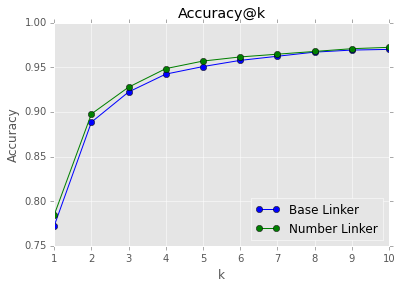

In [20]:
# Plot the results
plt.style.use('ggplot')

plt.title('Accuracy@k')
plt.ylabel('Accuracy')
plt.xlabel('k')

plt.plot(k_range, base_accuracy, marker='o', color='b', label='Base Linker')
plt.plot(k_range, num_accuracy, marker='o', color='g', label='Number Linker')

plt.legend(loc=4)
None

<b>
We can see that the extracted numbers positively affect our model. <br>
There are many more possible features to explore, and different distance functions to try. Read more in [our userguide](https://turi.com/learn/userguide/data_matching/introduction.html).
</b>

## <a id="r"></a> Exploring the radius

<b>Some times not all k results make sense, or we just don't want to present a user with too many possibilities. <br>
For this we have the radius parameter which serves as a distance threshold. </b>

In [21]:
results = num_linker.link(google, k=10, verbose=False)

print 'Accuracy:', accuracy_at(results, truth)
print 'Possible number of results to go through:', len(results)

Accuracy: 0.972307692308
Possible number of results to go through: 32260


In [22]:
results['distance'].show()

In [23]:
results = num_linker.link(google, k=None, radius=1.61, verbose=False)

print 'Accuracy:', accuracy_at(results, truth)
print 'Possible number of results to go through:', len(results)

Accuracy: 0.921538461538
Possible number of results to go through: 12853
